This is an interactive notebook to demonstrate the basics of signal detection theory.

This uses ipython widgets - based on examples here: https://github.com/ipython/ipywidgets/blob/138560172892f91983553e4f47ef61ea00723bd3/examples/Using%20Interact.ipynb

In [142]:
from ipywidgets import interact, interactive, fixed,FloatSlider,IntSlider
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy
import scipy.stats
from sklearn.metrics import auc
%matplotlib inline

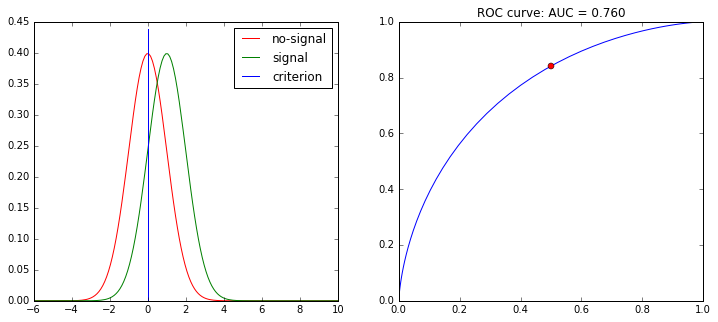

In [143]:
def plot_gaussians(dprime,criterion,sd_noise):
    sd=[sd_noise,1]
    limits=[-10,10]
    step=0.1
    x = numpy.linspace(limits[0],limits[1],numpy.round((limits[1]-limits[0])/step))
    y0=scipy.stats.norm.pdf(x,loc=0,scale=sd[0])
    y1=scipy.stats.norm.pdf(x,loc=dprime,scale=sd[1])
    
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(x,y0,color='red')
    plt.xlim([-6,10])
    plt.plot(x,y1,color='green')
    plt.plot([criterion,criterion],[0,numpy.max(numpy.hstack((y0,y1)))*1.1],color='blue')
    plt.legend(['no-signal','signal','criterion'])
    plt.subplot(1,2,2)
    crit=numpy.linspace(-5,5,100)
    fa=numpy.zeros(crit.shape[0])
    hits=numpy.zeros(crit.shape[0])
    for c in range(crit.shape[0]):
        fa[c]=1. - scipy.stats.norm.cdf(crit[c],loc=0,scale=sd[0])
        hits[c]=1. - scipy.stats.norm.cdf(crit[c],loc=dprime,scale=sd[1])
    plt.plot(fa,hits)
    plt.plot(1. - scipy.stats.norm.cdf(criterion,loc=0,scale=sd[0]),
             1. - scipy.stats.norm.cdf(criterion,loc=dprime,scale=sd[1]),
            marker='o', color='r')
    plt.title('ROC curve: AUC = %0.3f'%auc(fa,hits))


    #plt.plot(fa)
    plt.show()
    #return((y0,y1,hits,fa,crit,dprime))
    

_=interact(plot_gaussians, dprime=FloatSlider(description='dprime', min=0, max=5, step=0.1,value=1),
        criterion=FloatSlider(description='criterion', min=-6, max=6, step=0.1),
        sd_noise=FloatSlider(description='Noise SD', min=1., max=3, step=0.1,value=1))


Now let's add in the relative cost of the different outcomes.  We might imagine, for example, that the relative cost of missing a cancer (i.e. a "miss") is much higher than the cost of falsely claiming a cancer is present where there is none.  We can determine the hit and false alarm rates for each possible criterion and then compute the total cost under that criterion value; from this, we can determine the best criterion to minimize the total cost.

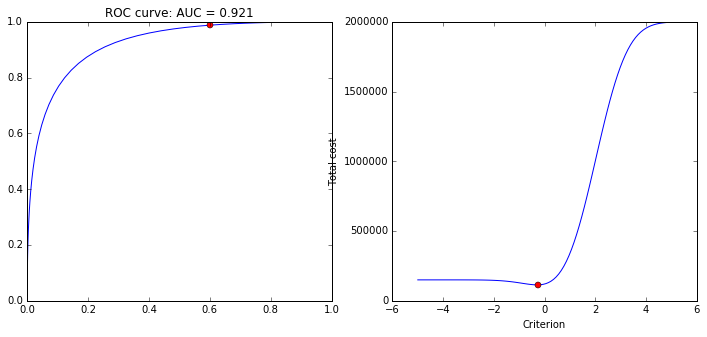

'Optimal criterion: -0.3'

In [144]:
def plot_gaussians_cost(dprime,cost_miss,cost_fa):
    sd=[1,1]
    limits=[-10,10]
    step=0.1
    x = numpy.linspace(limits[0],limits[1],numpy.round((limits[1]-limits[0])/step))
    y0=scipy.stats.norm.pdf(x,loc=0,scale=sd[0])
    y1=scipy.stats.norm.pdf(x,loc=dprime,scale=sd[1])
    
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    crit=numpy.linspace(-5,5,100)
    fa=numpy.zeros(crit.shape[0])
    hits=numpy.zeros(crit.shape[0])
    cost=numpy.zeros(crit.shape[0])
    for c in range(crit.shape[0]):
        fa[c]=1. - scipy.stats.norm.cdf(crit[c],loc=0,scale=sd[0])
        hits[c]=1. - scipy.stats.norm.cdf(crit[c],loc=dprime,scale=sd[1])
        cost[c]=fa[c]*cost_fa + (1-hits[c])*cost_miss
    optimal_criterion=crit[numpy.where(cost==numpy.min(cost))[0]][0]

    plt.plot(fa,hits)
    plt.plot(1. - scipy.stats.norm.cdf(optimal_criterion,loc=0,scale=sd[0]),
             1. - scipy.stats.norm.cdf(optimal_criterion,loc=dprime,scale=sd[1]),
            marker='o', color='r')
    plt.title('ROC curve: AUC = %0.3f'%auc(fa,hits))
    plt.subplot(1,2,2)
    plt.plot(crit,cost)
    plt.ylabel('Total cost')
    plt.xlabel('Criterion')
    plt.plot(optimal_criterion,numpy.min(cost),marker='o', color='r')
    #plt.plot(fa)
    plt.show()
    return('Optimal criterion: %0.1f'%optimal_criterion)
    #return((y0,y1,hits,fa,crit,dprime))
    

_=interact(plot_gaussians_cost, dprime=FloatSlider(description='dprime', min=0, max=5, step=0.1,value=2),
        sd_noise=FloatSlider(description='Noise SD', min=1., max=3, step=0.1,value=1),
        cost_miss=IntSlider(description='cost of miss', min=0, max=100000000, step=10000,value=2000000),
        cost_fa=IntSlider(description='cost of false alarm', min=0, max=100000000, step=10000,value=150000))




Now let's look at Bayesian decision theory.  Let's say that we want to detect cancer using a new blood test.  We need to know a few quantities:

* how sensitive is the test? p(test|cancer)
* how specific is the test? p(test|not cancer)
* how common is cancer? p(cancer)

First, let's look at a simple example of how to compute the posterior - p(cancer|test) - from these quantities.

'p(cancer|test)=0.679'

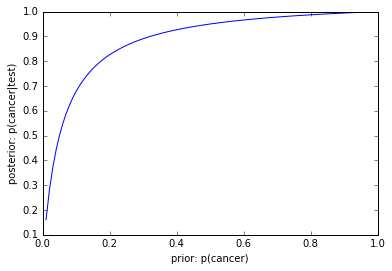

In [145]:
def compute_bayes(prior,p_pos,p_neg):
    return p_pos*prior / ( p_pos*prior + p_neg*(1-prior))

def plot_bayes(p_cancer,p_test_cancer,p_test_nocancer):
    p_cancer_test = compute_bayes(p_cancer,p_test_cancer,p_test_nocancer)
    priorvals=numpy.arange(0.01,0.99,0.01)
    plt.plot(priorvals,compute_bayes(priorvals,p_test_cancer,p_test_nocancer))
    plt.xlabel('prior: p(cancer)')
    plt.ylabel('posterior: p(cancer|test)')
    return 'p(cancer|test)=%0.3f'%p_cancer_test

_=interact(plot_bayes, p_cancer=FloatSlider(description='prior - p(cancer)', min=0.01, max=0.99, step=0.01,value=0.1),
        p_test_cancer=FloatSlider(description='hit rate - p(test|cancer)', min=0.01, max=0.99, step=0.01,value=0.95),
        p_test_nocancer=FloatSlider(description='false alarm rate - p(test|no cancer)', min=0.01, max=0.99, step=0.01,value=0.05))


